### Import Required Libraries

In [32]:
import string
import re
from numpy import array, argmax, random, take
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt

In [3]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [4]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [5]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [6]:
deu_eng = deu_eng[:50000,:]

In [7]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["They're coming again.", 'Sie kommen wieder.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2243605 (CK) & #6643044 (Felixjp)'],
       ["They're coming again.", 'Die kommen wieder.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2243605 (CK) & #6645385 (Felixjp)'],
       ["They're doing it now.", 'Sie tun es jetzt.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3740220 (CK) & #3815719 (nGerman)']],
      dtype='<U537')

In [8]:
# Remove punctuation 
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [9]:
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Theyre coming again', 'Sie kommen wieder',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2243605 (CK) & #6643044 (Felixjp)'],
       ['Theyre coming again', 'Die kommen wieder',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2243605 (CK) & #6645385 (Felixjp)'],
       ['Theyre doing it now', 'Sie tun es jetzt',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3740220 (CK) & #3815719 (nGerman)']],
      dtype='<U537')

In [10]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [11]:
deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['theyre coming again', 'sie kommen wieder',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2243605 (CK) & #6643044 (Felixjp)'],
       ['theyre coming again', 'die kommen wieder',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2243605 (CK) & #6645385 (Felixjp)'],
       ['theyre doing it now', 'sie tun es jetzt',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3740220 (CK) & #3815719 (nGerman)']],
      dtype='<U537')

In [12]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))
max(deu_l)
max(eng_l)

6

In [13]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

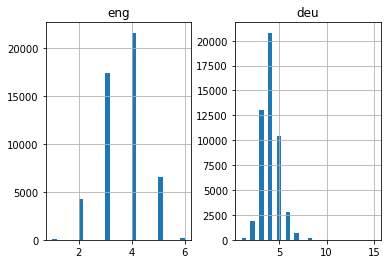

In [14]:
length_df.hist(bins = 30)
plt.show()

In [15]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [16]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6125


In [17]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10059


In [18]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [19]:
import pickle
with open('eng_tokenizer.pickle', 'wb') as handle:
    pickle.dump(eng_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
with open('deu_tokenizer.pickle', 'wb') as handle:
    pickle.dump(deu_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.1, random_state = 1)

In [22]:
test[:,0].shape

(5000,)

In [23]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [24]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [25]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [26]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [27]:
#@title Default title text
filename = 'arpanKaModel'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
71/71 [==============================] - ETA: 0s - loss: 3.2736
Epoch 1: val_loss improved from inf to 2.75588, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 169s 2s/step - loss: 3.2736 - val_loss: 2.7559
Epoch 2/30
71/71 [==============================] - ETA: 0s - loss: 2.6698
Epoch 2: val_loss improved from 2.75588 to 2.65595, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 160s 2s/step - loss: 2.6698 - val_loss: 2.6559
Epoch 3/30
71/71 [==============================] - ETA: 0s - loss: 2.4678
Epoch 3: val_loss improved from 2.65595 to 2.41956, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 162s 2s/step - loss: 2.4678 - val_loss: 2.4196
Epoch 4/30
71/71 [==============================] - ETA: 0s - loss: 2.2867
Epoch 4: val_loss improved from 2.41956 to 2.27797, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 163s 2s/step - loss: 2.2867 - val_loss: 2.2780
Epoch 5/30
71/71 [==============================] - ETA: 0s - loss: 2.1286
Epoch 5: val_loss improved from 2.27797 to 2.16938, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 152s 2s/step - loss: 2.1286 - val_loss: 2.1694
Epoch 6/30
71/71 [==============================] - ETA: 0s - loss: 1.9851
Epoch 6: val_loss improved from 2.16938 to 2.06589, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 153s 2s/step - loss: 1.9851 - val_loss: 2.0659
Epoch 7/30
71/71 [==============================] - ETA: 0s - loss: 1.8532
Epoch 7: val_loss improved from 2.06589 to 1.94604, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 155s 2s/step - loss: 1.8532 - val_loss: 1.9460
Epoch 8/30
71/71 [==============================] - ETA: 0s - loss: 1.7291
Epoch 8: val_loss improved from 1.94604 to 1.86327, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 151s 2s/step - loss: 1.7291 - val_loss: 1.8633
Epoch 9/30
71/71 [==============================] - ETA: 0s - loss: 1.6162
Epoch 9: val_loss improved from 1.86327 to 1.77218, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 152s 2s/step - loss: 1.6162 - val_loss: 1.7722
Epoch 10/30
71/71 [==============================] - ETA: 0s - loss: 1.5082
Epoch 10: val_loss improved from 1.77218 to 1.69571, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 151s 2s/step - loss: 1.5082 - val_loss: 1.6957
Epoch 11/30
71/71 [==============================] - ETA: 0s - loss: 1.4079
Epoch 11: val_loss improved from 1.69571 to 1.62981, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 154s 2s/step - loss: 1.4079 - val_loss: 1.6298
Epoch 12/30
71/71 [==============================] - ETA: 0s - loss: 1.3102
Epoch 12: val_loss improved from 1.62981 to 1.56584, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 153s 2s/step - loss: 1.3102 - val_loss: 1.5658
Epoch 13/30
71/71 [==============================] - ETA: 0s - loss: 1.2209
Epoch 13: val_loss improved from 1.56584 to 1.50710, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 151s 2s/step - loss: 1.2209 - val_loss: 1.5071
Epoch 14/30
71/71 [==============================] - ETA: 0s - loss: 1.1331
Epoch 14: val_loss improved from 1.50710 to 1.48653, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 149s 2s/step - loss: 1.1331 - val_loss: 1.4865
Epoch 15/30
71/71 [==============================] - ETA: 0s - loss: 1.0541
Epoch 15: val_loss improved from 1.48653 to 1.42046, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 151s 2s/step - loss: 1.0541 - val_loss: 1.4205
Epoch 16/30
71/71 [==============================] - ETA: 0s - loss: 0.9777
Epoch 16: val_loss improved from 1.42046 to 1.37645, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 149s 2s/step - loss: 0.9777 - val_loss: 1.3765
Epoch 17/30
71/71 [==============================] - ETA: 0s - loss: 0.9051
Epoch 17: val_loss improved from 1.37645 to 1.34422, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 150s 2s/step - loss: 0.9051 - val_loss: 1.3442
Epoch 18/30
71/71 [==============================] - ETA: 0s - loss: 0.8372
Epoch 18: val_loss improved from 1.34422 to 1.31874, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 150s 2s/step - loss: 0.8372 - val_loss: 1.3187
Epoch 19/30
71/71 [==============================] - ETA: 0s - loss: 0.7745
Epoch 19: val_loss improved from 1.31874 to 1.29409, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 155s 2s/step - loss: 0.7745 - val_loss: 1.2941
Epoch 20/30
71/71 [==============================] - ETA: 0s - loss: 0.7124
Epoch 20: val_loss improved from 1.29409 to 1.26067, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 151s 2s/step - loss: 0.7124 - val_loss: 1.2607
Epoch 21/30
71/71 [==============================] - ETA: 0s - loss: 0.6573
Epoch 21: val_loss improved from 1.26067 to 1.24780, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 779s 11s/step - loss: 0.6573 - val_loss: 1.2478
Epoch 22/30
71/71 [==============================] - ETA: 0s - loss: 0.6055
Epoch 22: val_loss improved from 1.24780 to 1.22036, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 153s 2s/step - loss: 0.6055 - val_loss: 1.2204
Epoch 23/30
71/71 [==============================] - ETA: 0s - loss: 0.5555
Epoch 23: val_loss improved from 1.22036 to 1.20276, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 155s 2s/step - loss: 0.5555 - val_loss: 1.2028
Epoch 24/30
71/71 [==============================] - ETA: 0s - loss: 0.5115
Epoch 24: val_loss improved from 1.20276 to 1.19003, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 154s 2s/step - loss: 0.5115 - val_loss: 1.1900
Epoch 25/30
71/71 [==============================] - ETA: 0s - loss: 0.4678
Epoch 25: val_loss improved from 1.19003 to 1.17832, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 153s 2s/step - loss: 0.4678 - val_loss: 1.1783
Epoch 26/30
71/71 [==============================] - ETA: 0s - loss: 0.4300
Epoch 26: val_loss improved from 1.17832 to 1.17755, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 151s 2s/step - loss: 0.4300 - val_loss: 1.1775
Epoch 27/30
71/71 [==============================] - ETA: 0s - loss: 0.3926
Epoch 27: val_loss improved from 1.17755 to 1.16977, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 152s 2s/step - loss: 0.3926 - val_loss: 1.1698
Epoch 28/30
71/71 [==============================] - ETA: 0s - loss: 0.3612
Epoch 28: val_loss did not improve from 1.16977
71/71 [==============================] - 140s 2s/step - loss: 0.3612 - val_loss: 1.1727
Epoch 29/30
71/71 [==============================] - ETA: 0s - loss: 0.3287
Epoch 29: val_loss improved from 1.16977 to 1.15986, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 166s 2s/step - loss: 0.3287 - val_loss: 1.1599
Epoch 30/30
71/71 [==============================] - ETA: 0s - loss: 0.3009
Epoch 30: val_loss improved from 1.15986 to 1.15639, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


71/71 [==============================] - 180s 3s/step - loss: 0.3009 - val_loss: 1.1564


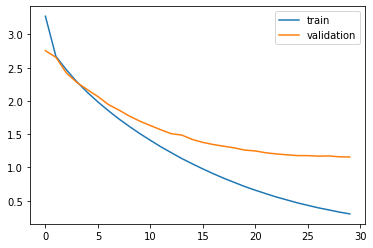

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [29]:
testX.shape

(5000, 8)

In [33]:
model = load_model('arpanKaModel')
preds = np.argmax(model.predict(testX),axis=-1)

157/157 [==============================] - 14s 78ms/step


In [34]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [35]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [36]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [37]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

In [ ]:
pred_df.tail(15)

In [ ]:
pred_df.tail(15)

In [38]:
pred_df.sample(15)

,actual,predicted
1589,he was unimpressed,he was tenacious
711,you may have it,you can have it
236,tom believed you,tom believed you
2597,its getting late,it late
4825,tom was very shy,tom was very shy
2910,tom is her brother,tom is your brother
1026,i need inspiration,i need caffeine
3157,id like a fork,id like a answer
4934,do something,do something do
3338,stop looking down,the looks was very
